# Taller machine learning I

**Integrantes**

* Nombre: Maria del mar Ipia Guzmán
* Cédula: 1214726595
* Correo: maria.ipia@udea.edu.co

  

- Nombre: Johan Arbey Vargas Mejía
- Cédula: 1152195956
- Correo: johan.vargas@udea.edu.co

## Librerías

In [417]:
import json
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import zipfile

from sklearn import metrics
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler


%matplotlib inline
plt.style.use('ggplot')

In [107]:
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', None)

## Configuración del API de Kaggle

1. Iniciar sesión en tu cuenta de Kaggle en `https://www.kaggle.com`.
2. Hacer clic en tu foto de perfil en la esquina superior derecha de la página y seleccionar "Cuenta" en el menú desplaable.
3. Desplazar hacia abajo hasta la sección `API` y haz clic en `Crear nueva clave de API`.
4. Se descargará automáticamente el archivo `kaggle.json` que contiene las credenciales de API de Kaggle.
5. Guardar el archivo kaggle.json en una `input`.

In [2]:
def set_environ_kaggle(path: str) -> None:
    """Establece las variables de entorno para la autenticación 
     de la API de Kaggle.

    Args:
        path: Ruta al archivo kaggle.json que contiene las 
         credenciales de API de Kaggle.

    """
    with open(path, 'r') as f:
        data = json.load(f)

    os.environ['KAGGLE_USERNAME'] = data['username']
    os.environ['KAGGLE_KEY'] = data['key']

In [3]:
kaggle_path = os.path.join('..', 'input', 'kaggle.json')

In [4]:
# Se configura el entorno para autenticarse en KAGGLE.
set_environ_kaggle(kaggle_path)

## Descargar el conjunto de datos

In [5]:
from kaggle.api.kaggle_api_extended import KaggleApi

In [6]:
def download_dataset(dataset_name: str, output_path: str) -> None:
    """Descarga un conjunto de datos de Kaggle y lo extrae en 
     la ubicación especificada.

    Args:
        dataset_name: Nombre del conjunto de datos en Kaggle.
         Debe seguir el formato 'nombre-usuario/nombre-conjunto-datos'.
        output_path: Ruta donde se extraerán los archivos 
         del conjunto de datos.

    """
    api = KaggleApi()
    api.authenticate()

    api.dataset_download_files(dataset_name)

    file_name = dataset_name.split('/')[1]
    with zipfile.ZipFile(f'{file_name}.zip', 'r') as zip_ref:
        zip_ref.extractall(output_path)

    os.remove(f'{file_name}.zip')

El dataset se encuentra en el link: https://www.kaggle.com/datasets/datasnaek/youtube-new?select=MXvideos.csv

Notar que el nombre del conjunto de datos está despues `datasets/` y va hasta el signo `?`

In [7]:
dataset_name = 'datasnaek/youtube-new'

In [11]:
data_path = os.path.join('..', 'data')

In [9]:
download_dataset(dataset_name, data_path)

## Funciones utils

### Gráficas

In [162]:
def pie_plot(data: pd.DataFrame, col: str) -> None:
    """Genera un gráfico de pastel basado en una columna de un DataFrame.

    Args:
        data (pd.DataFrame): El DataFrame que contiene los datos.
        col (str): El nombre de la columna a graficar.

    Returns:
        None: Muestra el gráfico de pastel.

    """
    plt.figure(figsize=(8, 5))
    datos = data[col]
    labels = data.index
    
    # Se agregan colores con plt.cm estableciendo un color para cada espacio en el 
    # diagrama, por eso se usa un linspace de la misma magnitud de los datos.
    colors = plt.cm.RdYlGn(np.linspace(0.1, 0.7, len(datos)))
    
    # Generación del diagrama circular
    patches, texts = plt.pie(datos, labels=labels, colors=colors)

    # Para que siempre se vea como un círculo
    plt.axis('equal')
    
    # Se eliminan las líneas
    plt.rcParams['patch.linewidth'] = 0
    
    # Estimación porcentaje
    porcent = 100 * datos / sum(datos)
    # Lista que será expuesta en la legenda
    labels = ['{0} - {1:1.1f} %'.format(i,j) for i, j in zip(labels, porcent)]
    
    # Se genera la legenda
    # bbox_to_anchor especifica en coordenadas la posición de la legenda
    plt.legend(patches, labels, bbox_to_anchor=(-0.1, 1.), fontsize=8)
    
    plt.show()

In [237]:
def box_plot(df: pd.DataFrame, showfliers: bool = True):
    """Genera un diagrama de cajas utilizando el mapa de colores RdYlGn.

    Args:
        df (pd.DataFrame): El DataFrame que se utilizará para generar 
         el diagrama de cajas.
        showfliers (bool): Indica si se muestran o no los valores 
         atípicos en el diagrama de cajas. Valor predeterminado es True.

    Returns:
        None: Muestra el gráfico de barras.
        
    """
    # Generar el diagrama de cajas utilizando df.plot(kind='box')
    ax = df.plot(kind='box', patch_artist=True, figsize=(8, 5), showfliers=showfliers, vert=False)
    
    # Configurar el mapa de colores
    cmap = plt.cm.RdYlGn
    
    # Personalizar el color de las cajas utilizando el mapa de colores
    for patch, color in zip(ax.artists, cmap(np.linspace(0.1, 0.9, len(ax.artists)))):
        patch.set_facecolor(color)

    plt.show()

### Limpieza

In [215]:
def find_missing(df: pd.DataFrame) -> pd.DataFrame:
    """Encuentra los valores faltantes en un DataFrame y devuelve un nuevo DataFrame
     que muestra la cantidad de valores faltantes y el porcentaje correspondiente.

    Args:
        df (pd.DataFrame): El DataFrame que se va a analizar.

    Returns:
        pd.DataFrame: Un nuevo DataFrame que muestra las columnas, la cantidad de
        valores faltantes y el porcentaje de valores faltantes para cada columna.

    """
    lista = []
    for col in df.columns:
        num = df[df[col].isnull()].shape[0]
        lista.append(num)
    
    dic = {
        'Columnas': df.columns,
        'Faltantes': lista}
    df_faltantes = pd.DataFrame(dic)
    
    df_faltantes['Porcentaje'] = df_faltantes['Faltantes'] / df.shape[0]
    
    return df_faltantes

## Exploración de datos

Archivo JSON con la información de las categorías de los videos.

In [297]:
with open(os.path.join(data_path, 'US_category_id.json'), 'r') as f:
    data = json.load(f)

In [298]:
ls = []
for diccionario in data['items']:
    row = {
        'category_id': diccionario['id'],
        'category': diccionario['snippet']['title']
    }
    
    ls.append(row)

categories = pd.DataFrame(ls)

In [299]:
categories.head()

,category_id,category
0,1,Film & Animation
1,2,Autos & Vehicles
2,10,Music
3,15,Pets & Animals
4,17,Sports


### Lectura de datos

In [300]:
path = os.path.join(data_path, 'USvideos.csv')
youtube = pd.read_csv(path, encoding='latin-1', converters={'category_id': str})

In [301]:
print(f'Tamaño del dataset: {youtube.shape}')

Tamaño del dataset: (40949, 16)


In [302]:
youtube.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40949 entries, 0 to 40948
Data columns (total 16 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   video_id                40949 non-null  object
 1   trending_date           40949 non-null  object
 2   title                   40949 non-null  object
 3   channel_title           40949 non-null  object
 4   category_id             40949 non-null  object
 5   publish_time            40949 non-null  object
 6   tags                    40949 non-null  object
 7   views                   40949 non-null  int64 
 8   likes                   40949 non-null  int64 
 9   dislikes                40949 non-null  int64 
 10  comment_count           40949 non-null  int64 
 11  thumbnail_link          40949 non-null  object
 12  comments_disabled       40949 non-null  bool  
 13  ratings_disabled        40949 non-null  bool  
 14  video_error_or_removed  40949 non-null  bool  
 15  de

### Columna objetivo

In [303]:
youtube = pd.merge(
    youtube,
    categories,
    on='category_id',
    how='left')

In [304]:
categories_youtube = youtube.groupby('category').agg({'video_id': 'count'})

In [305]:
categories_youtube['per'] = categories_youtube['video_id'] / categories_youtube['video_id'].sum() * 100

In [306]:
categories_youtube = categories_youtube.sort_values(by='video_id', ascending=False)

In [307]:
categories_youtube

,video_id,per
category,,
Entertainment,9964,24.332707
Music,6472,15.805026
Howto & Style,4146,10.124789
Comedy,3457,8.442209
People & Blogs,3210,7.839019
News & Politics,2487,6.073408
Science & Technology,2401,5.863391
Film & Animation,2345,5.726636
Sports,2174,5.309043


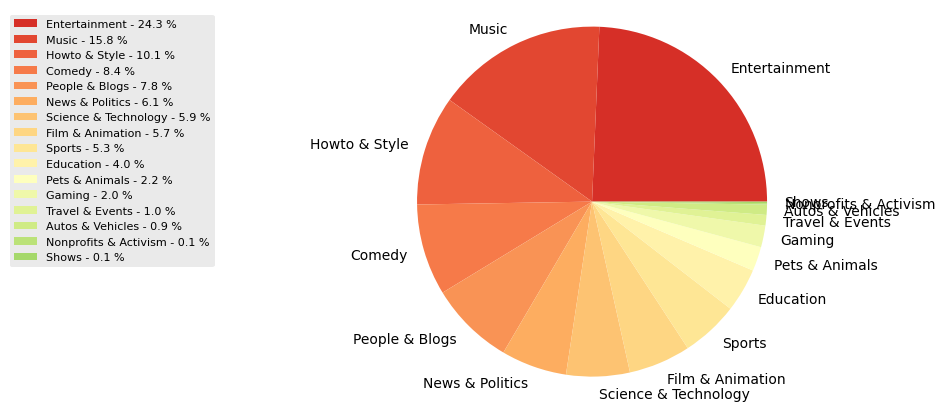

In [308]:
pie_plot(categories_youtube, 'video_id')

#### Agrupación de categorias de bajo porcentaje de participación

In [309]:
cats = ['Education', 'Pets & Animals', 'Gaming', 'Travel & Events',
        'Autos & Vehicles', 'Nonprofits & Activism', 'Shows']

for cat in cats:
    cond = youtube['category'] == cat
    youtube.loc[cond, 'category'] = 'Other'

In [310]:
ids = categories[categories['category'].isin(cats)]['category_id'].unique()

for id in ids:
    cond = youtube['category_id'] == id
    youtube.loc[cond, 'category_id'] = '50'

In [311]:
categories_youtube = youtube.groupby('category').agg({'video_id': 'count'})

In [312]:
categories_youtube

,video_id
category,
Comedy,3457
Entertainment,9964
Film & Animation,2345
Howto & Style,4146
Music,6472
News & Politics,2487
Other,4293
People & Blogs,3210
Science & Technology,2401


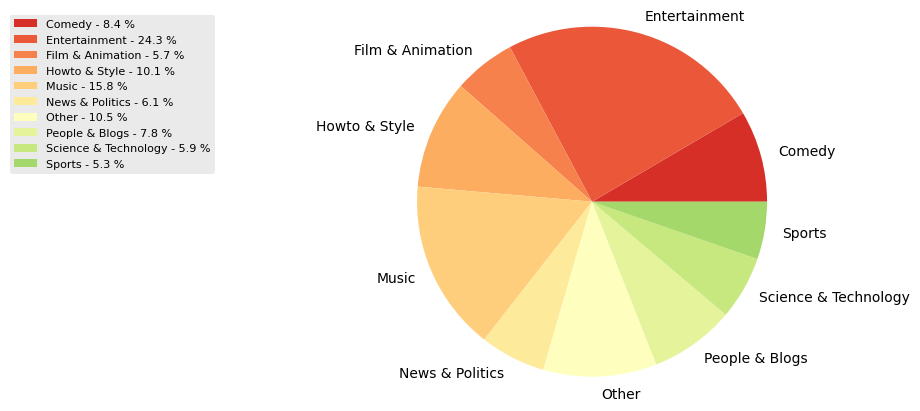

In [313]:
pie_plot(categories_youtube, 'video_id')

### Imputación

In [314]:
missing_values = find_missing(youtube)

In [315]:
missing_values

,Columnas,Faltantes,Porcentaje
0,video_id,0,0.00000
1,trending_date,0,0.00000
2,title,0,0.00000
3,channel_title,0,0.00000
4,category_id,0,0.00000
5,publish_time,0,0.00000
6,tags,0,0.00000
7,views,0,0.00000
8,likes,0,0.00000
9,dislikes,0,0.00000


`description` no será usada en el modelo de clasificación por lo que no hay necesidad de realizar imputación de datos

### Datos atípicos

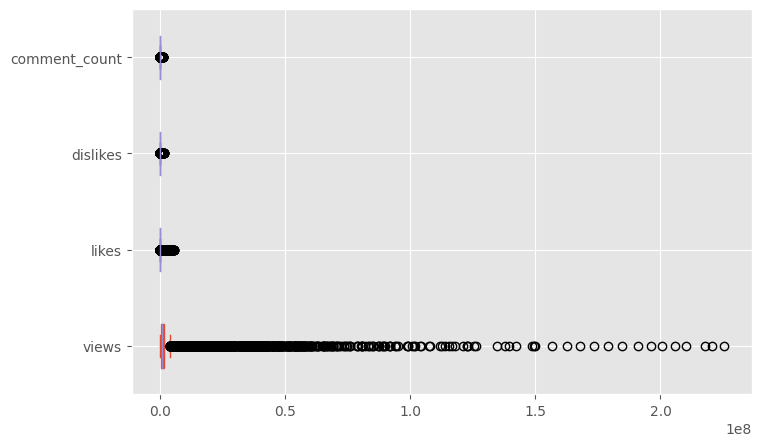

In [316]:
box_plot(youtube)

* Se seleccionan las columnas numéricas para escalar y tener un diagrama de cajas con las caracteríscas en la misma escala

In [317]:
youtube_numeric = youtube.select_dtypes(include=['float64', 'int64'])

In [318]:
youtube_numeric

,views,likes,dislikes,comment_count
0,748374,57527,2966,15954
1,2418783,97185,6146,12703
2,3191434,146033,5339,8181
3,343168,10172,666,2146
4,2095731,132235,1989,17518
...,...,...,...,...
40944,1685609,38160,1385,2657
40945,1064798,60008,382,3936
40946,1066451,48068,1032,3992
40947,5660813,192957,2846,13088


In [319]:
min_max = MinMaxScaler()

numeric_scale = min_max.fit_transform(youtube_numeric)

numeric_scale = pd.DataFrame(numeric_scale, columns=youtube_numeric.columns)

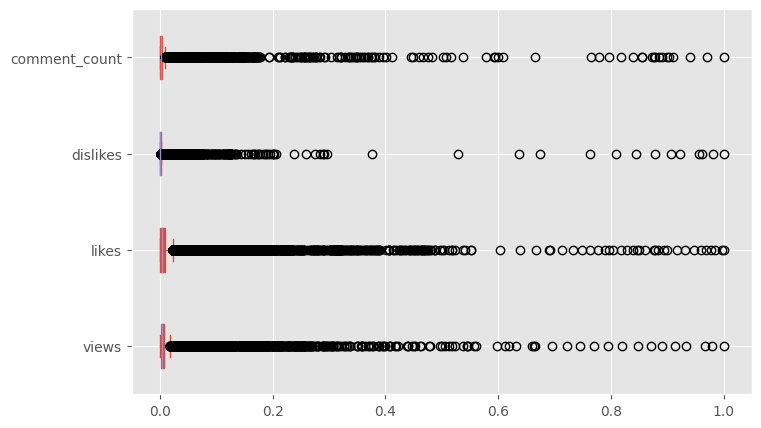

In [320]:
box_plot(numeric_scale)

* Observemos los datos sin presencia de outliers para intentar tener una vista clara de los datos

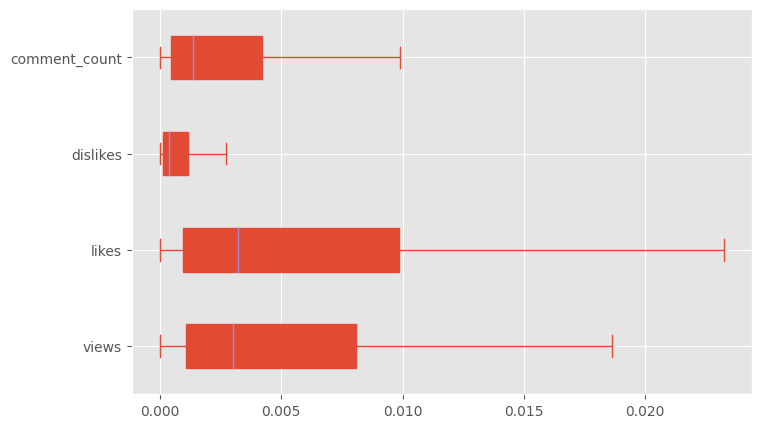

In [321]:
box_plot(numeric_scale, showfliers=False)

### Transformaciones

* Cantidad de días para convertirse en tendencia

In [322]:
youtube['trending_date'] = pd.to_datetime(youtube['trending_date'], format='%y.%d.%m')

In [323]:
youtube['publish_time'] = pd.to_datetime(youtube['publish_time'])

In [346]:
youtube['days'] = (youtube['trending_date'] - youtube['publish_time'].dt.tz_localize(None)).dt.days

* Longitud del titulo del video

In [347]:
youtube['title_length'] = youtube['title'].apply(lambda x: len(x))

* Cantidad de tags con las que cuenta el video

In [348]:
youtube['tag_count'] = youtube['tags'].apply(lambda x: len(x.split('|')))

### Elección de características

In [350]:
youtube.columns

Index(['video_id', 'trending_date', 'title', 'channel_title', 'category_id',
       'publish_time', 'tags', 'views', 'likes', 'dislikes', 'comment_count',
       'thumbnail_link', 'comments_disabled', 'ratings_disabled',
       'video_error_or_removed', 'description', 'category', 'days',
       'title_length', 'tag_count'],
      dtype='object')

In [398]:
columnas = ['views', 'likes', 'dislikes', 'comment_count', 
            'days','title_length', 'tag_count', 'category', ]

In [399]:
youtube_model = youtube.loc[:, columnas]

In [400]:
youtube_model

,views,likes,dislikes,comment_count,days,title_length,tag_count,category
0,748374,57527,2966,15954,0,34,1,People & Blogs
1,2418783,97185,6146,12703,0,62,4,Entertainment
2,3191434,146033,5339,8181,1,53,23,Comedy
3,343168,10172,666,2146,0,32,27,Entertainment
4,2095731,132235,1989,17518,1,24,14,Entertainment
...,...,...,...,...,...,...,...,...
40944,1685609,38160,1385,2657,26,28,14,Other
40945,1064798,60008,382,3936,26,26,1,People & Blogs
40946,1066451,48068,1032,3992,26,84,24,Entertainment
40947,5660813,192957,2846,13088,27,35,22,Film & Animation


# Modelo de clasifiación

* Aplicamos LabelEncoder para cambiar categorias en el modelo

In [401]:
le = LabelEncoder()
y_encoded = le.fit_transform(youtube_model['category'])

In [402]:
for i, categoria in enumerate(le.classes_):
    print(f"Número: {i}, Categoría: {categoria}")

Número: 0, Categoría: Comedy
Número: 1, Categoría: Entertainment
Número: 2, Categoría: Film & Animation
Número: 3, Categoría: Howto & Style
Número: 4, Categoría: Music
Número: 5, Categoría: News & Politics
Número: 6, Categoría: Other
Número: 7, Categoría: People & Blogs
Número: 8, Categoría: Science & Technology
Número: 9, Categoría: Sports


In [403]:
x_model = youtube_model.drop('category', axis=1)

* Escalamos los datos

In [404]:
min_max = MinMaxScaler()

x = min_max.fit_transform(x_model)

x = pd.DataFrame(x, columns=x_model.columns)

## División del conjunto de datos

In [405]:
x_train, x_test, y_train, y_test = train_test_split(
    x, y_encoded, train_size=0.8, random_state=1234, shuffle=True
)

In [406]:
print("Tamaño del conjunto de entrenamiento:")
print("x_train:", x_train.shape)
print("y_train:", y_train.shape)

print("Tamaño del conjunto de prueba:")
print("x_test:", x_test.shape)
print("y_test:", y_test.shape)

Tamaño del conjunto de entrenamiento:
x_train: (32759, 7)
y_train: (32759,)
Tamaño del conjunto de prueba:
x_test: (8190, 7)
y_test: (8190,)


## Entrenamiento y testeo

### Random Forest

In [422]:
random_forest = RandomForestClassifier(n_estimators=100, random_state=1234)

In [423]:
random_forest.fit(x_train, y_train)

RandomForestClassifier(random_state=1234)

In [424]:
y_pred = random_forest.predict(x_test)

In [425]:
print("modelRanForest:", metrics.accuracy_score(y_test, y_pred))

modelRanForest: 0.9070818070818071


In [426]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.92      0.88      0.90       672
           1       0.85      0.94      0.89      2004
           2       0.97      0.87      0.92       463
           3       0.91      0.89      0.90       815
           4       0.91      0.94      0.92      1317
           5       0.92      0.93      0.92       486
           6       0.94      0.87      0.91       914
           7       0.96      0.89      0.92       581
           8       0.95      0.86      0.90       514
           9       0.95      0.87      0.91       424

    accuracy                           0.91      8190
   macro avg       0.93      0.90      0.91      8190
weighted avg       0.91      0.91      0.91      8190



### MLPClassifier

In [418]:
clf = MLPClassifier(hidden_layer_sizes=(100, 100), activation='relu', random_state=1234)

In [419]:
clf.fit(x_train, y_train)

C:\Users\Usuario\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPClassifier(hidden_layer_sizes=(100, 100), random_state=1234)

In [420]:
y_pred = clf.predict(x_test)

In [421]:
print("ModelNN:", metrics.accuracy_score(y_test, y_pred))

ModelNN: 0.4186813186813187


###  SVM (Support Vector Machine)

In [427]:
clf = svm.SVC(kernel='linear', probability = True)

In [428]:
clf.fit(x_train, y_train)

SVC(kernel='linear', probability=True)

In [429]:
y_pred = clf.predict(x_test)

In [430]:
print("modelSVC:", metrics.accuracy_score(y_test, y_pred))

modelSVC: 0.29816849816849816
